# Fit Demo -- Simulated AGN
---------------------------
Simulate data with the AGN module included, fit it, and see how close to the input parameters we
get.

## Imports

In [1]:
import numpy as np
import astropy.units as u
from corner import corner
import matplotlib.pyplot as plt
plt.style.use('ebm-dejavu')
%matplotlib inline

from lightning import Lightning
from lightning.priors import UniformPrior

## Initialize Lightning

In [2]:
filter_labels = ['SDSS_u', 'SDSS_g', 'SDSS_r', 'SDSS_i', 'SDSS_z',
                 'IRAC_CH1', 'IRAC_CH2', 'IRAC_CH3', 'IRAC_CH4',
                 'MIPS_CH1',
                 'PACS_green', 'PACS_red']

# Redshift 0, default stellar age bins
l = Lightning(filter_labels, 
              lum_dist=10.0, # Mpc
              SFH_type='Piecewise-Constant',
              atten_type='Modified-Calzetti',
              dust_emission=True,
              agn_emission=True,
              agn_polar_dust=True,
              print_setup_time=True)

/Users/Erik/Documents/Research/lightning/plightning/lightning/get_filters.py:143: RuntimeWarning: invalid value encountered in true_divide
  transm_norm_interp = transm_interp / trapz(transm_interp, wave_grid)


0.050 s elapsed in _get_filters
0.000 s elapsed in _get_wave_obs
0.482 s elapsed in stellar model setup
0.000 s elapsed in dust attenuation model setup
1.767 s elapsed in dust emission model setup
0.455 s elapsed in agn emission model setup
0.000 s elapsed in X-ray model setup
2.755 s elapsed total


In [4]:
l.print_params(verbose=True)


Piecewise-Constant
Parameter  Lo  Hi              Description
--------- --- --- ------------------------
    psi_1 0.0 inf SFR in stellar age bin 1
    psi_2 0.0 inf SFR in stellar age bin 2
    psi_3 0.0 inf SFR in stellar age bin 3
    psi_4 0.0 inf SFR in stellar age bin 4
    psi_5 0.0 inf SFR in stellar age bin 5

Modified-Calzetti
      Parameter   Lo  Hi                                              Description
--------------- ---- --- --------------------------------------------------------
mcalz_tauV_diff  0.0 inf                         Optical depth of the diffuse ISM
    mcalz_delta -inf inf      Deviation from the Calzetti+2000 UV power law slope
  mcalz_tauV_BC  0.0 inf Optical depth of the birth cloud in star forming regions

DL07-Dust
      Parameter     Lo       Hi                                                             Description
--------------- ------ -------- -----------------------------------------------------------------------
dl07_dust_alpha  -10.0      4.0

## Fake some data

In [5]:
# This is a type 2 AGN, so the effect of the polar dust model
# is limited to boosting the IR emission
params = np.array([1,1,1,1,1,
                   0.3, 0.0, 0.0,
                   2, 1, 3e5, 0.1, 0.01,
                   11, 0.5, 7, 0.1])

Lmod, _ = l.get_model_lnu(params)

snr = 10.0

rng = np.random.default_rng()

Lsim = rng.normal(loc=Lmod, scale=Lmod / snr)
Lsim_unc = Lsim / snr

# A silly step, converting the data to mJy just so lightning can convert back to Lsun Hz-1
DL = 10 * u.Mpc

fsim = (Lsim * u.Lsun / u.Hz / (4 * np.pi * DL**2)).to(u.mJy).value
fsim_unc = (Lsim_unc  * u.Lsun / u.Hz / (4 * np.pi * DL**2)).to(u.mJy).value

# Note the warning generated by this step -- the minimum luminosity distance is probably something
# we ought to change; we'll want to add the option to specify a luminosity distance rather than
# a redshift for very nearby galaxies.
l.flux_obs = fsim
l.flux_unc = fsim_unc

## Fit with `emcee`

In [7]:
p = np.array([1,1,1,1,1,
              0.3, 0.0, 0.0,
              2, 1, 3e5, 0.1, 0.01,
              11, 0.5, 7, 0.1])

# Currently the setup is to provide this mask that tells
# lightning which parameters are constant
const_dim = np.array([False, False, False, False, False,
                      False, True, True,
                      True, False, True, False, False,
                      False, False, True, False])

priors = [UniformPrior([0, 1e1]), # SFH
          UniformPrior([0, 1e1]),
          UniformPrior([0, 1e1]),
          UniformPrior([0, 1e1]),
          UniformPrior([0, 1e1]),
          UniformPrior([0, 3]), # tauV
          UniformPrior([-3, 3]), # delta
          None, # tauV birth cloud
          None, # alpha
          UniformPrior([0.1, 25]), # Umin
          None, # Umax
          UniformPrior([0,1]), # gamma
          UniformPrior([0.0047, 0.0458]), # q_PAH
          UniformPrior([10, 12]), # L_AGN
          UniformPrior([0,1]), # cos i
          None, # tau97
          UniformPrior([0,1])
         ]

var_dim = ~const_dim

# Starting the MCMC in a very small Gaussian ball around the 'true' parameters
p0 = p[None, :] + rng.normal(loc=0, scale=1e-3, size=(75, len(p)))
p0[:, const_dim] = p[const_dim]

# Will print a tqdm progress bar -- note that the pure models s-1 throughput
# is the number of iterations s-1 that it shows multiplied by the number of walkers.
mcmc = l.fit(p0,
             method='emcee',
             Nwalkers=75,
             Nsteps=5000,
             const_dim=const_dim,
             priors=priors
             )

  4%|▍         | 201/5000 [00:23<07:50, 10.20it/s]/Users/Erik/Documents/Research/lightning/plightning/lightning/lightning.py:1443: RuntimeWarning: divide by zero encountered in log
  log_prior[ib_mask] = np.log(np.prod(prior_arr, axis=1))
100%|██████████| 5000/5000 [07:53<00:00, 10.57it/s]


Check on the acceptance fraction and construct the final chain:

In [8]:
print('MCMC mean acceptance fraction: %.3f' % (np.mean(mcmc.acceptance_fraction)))
# The autocorrelation time is <= 500; emcee is gonna tell us that the esimate of the
# autocorrelation time is bad because we haven't run a long enough chain (it's right)
# so the below line is commented out
#print('MCMC mean autocorrelation time: %.1f' % (np.mean(mcmc.get_autocorr_time())))

MCMC mean acceptance fraction: 0.189


In [10]:
chain = mcmc.get_chain(discard=1000, thin=250, flat=True)[-1000:, :]
logprob_chain = mcmc.get_log_prob(discard=1000, thin=250, flat=True)[-1000:]

In [11]:
# Reassembling the parameter array by including the constant parameters
# since the new plot functions want the whole set.
param_arr = np.zeros((chain.shape[0], l.Nparams))
param_arr[:, const_dim] = p[None, const_dim]
param_arr[:, var_dim] = chain

### Chain Plot
We'll make the traditional chain plot, for the SFH:

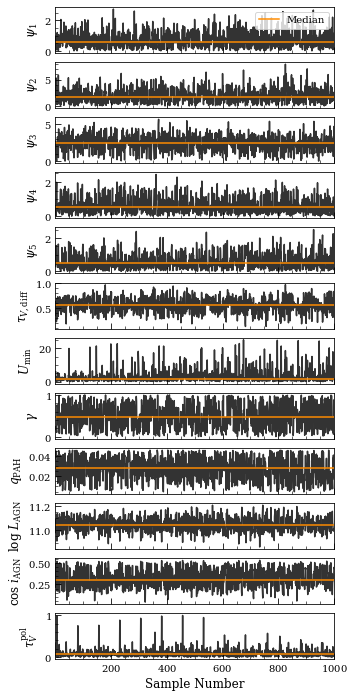

In [12]:
from lightning.plots import chain_plot

fig, axs = chain_plot(l, param_arr, color='k', alpha=0.8)

### Corner Plot
And now a corner plot for the whole set of parameters:

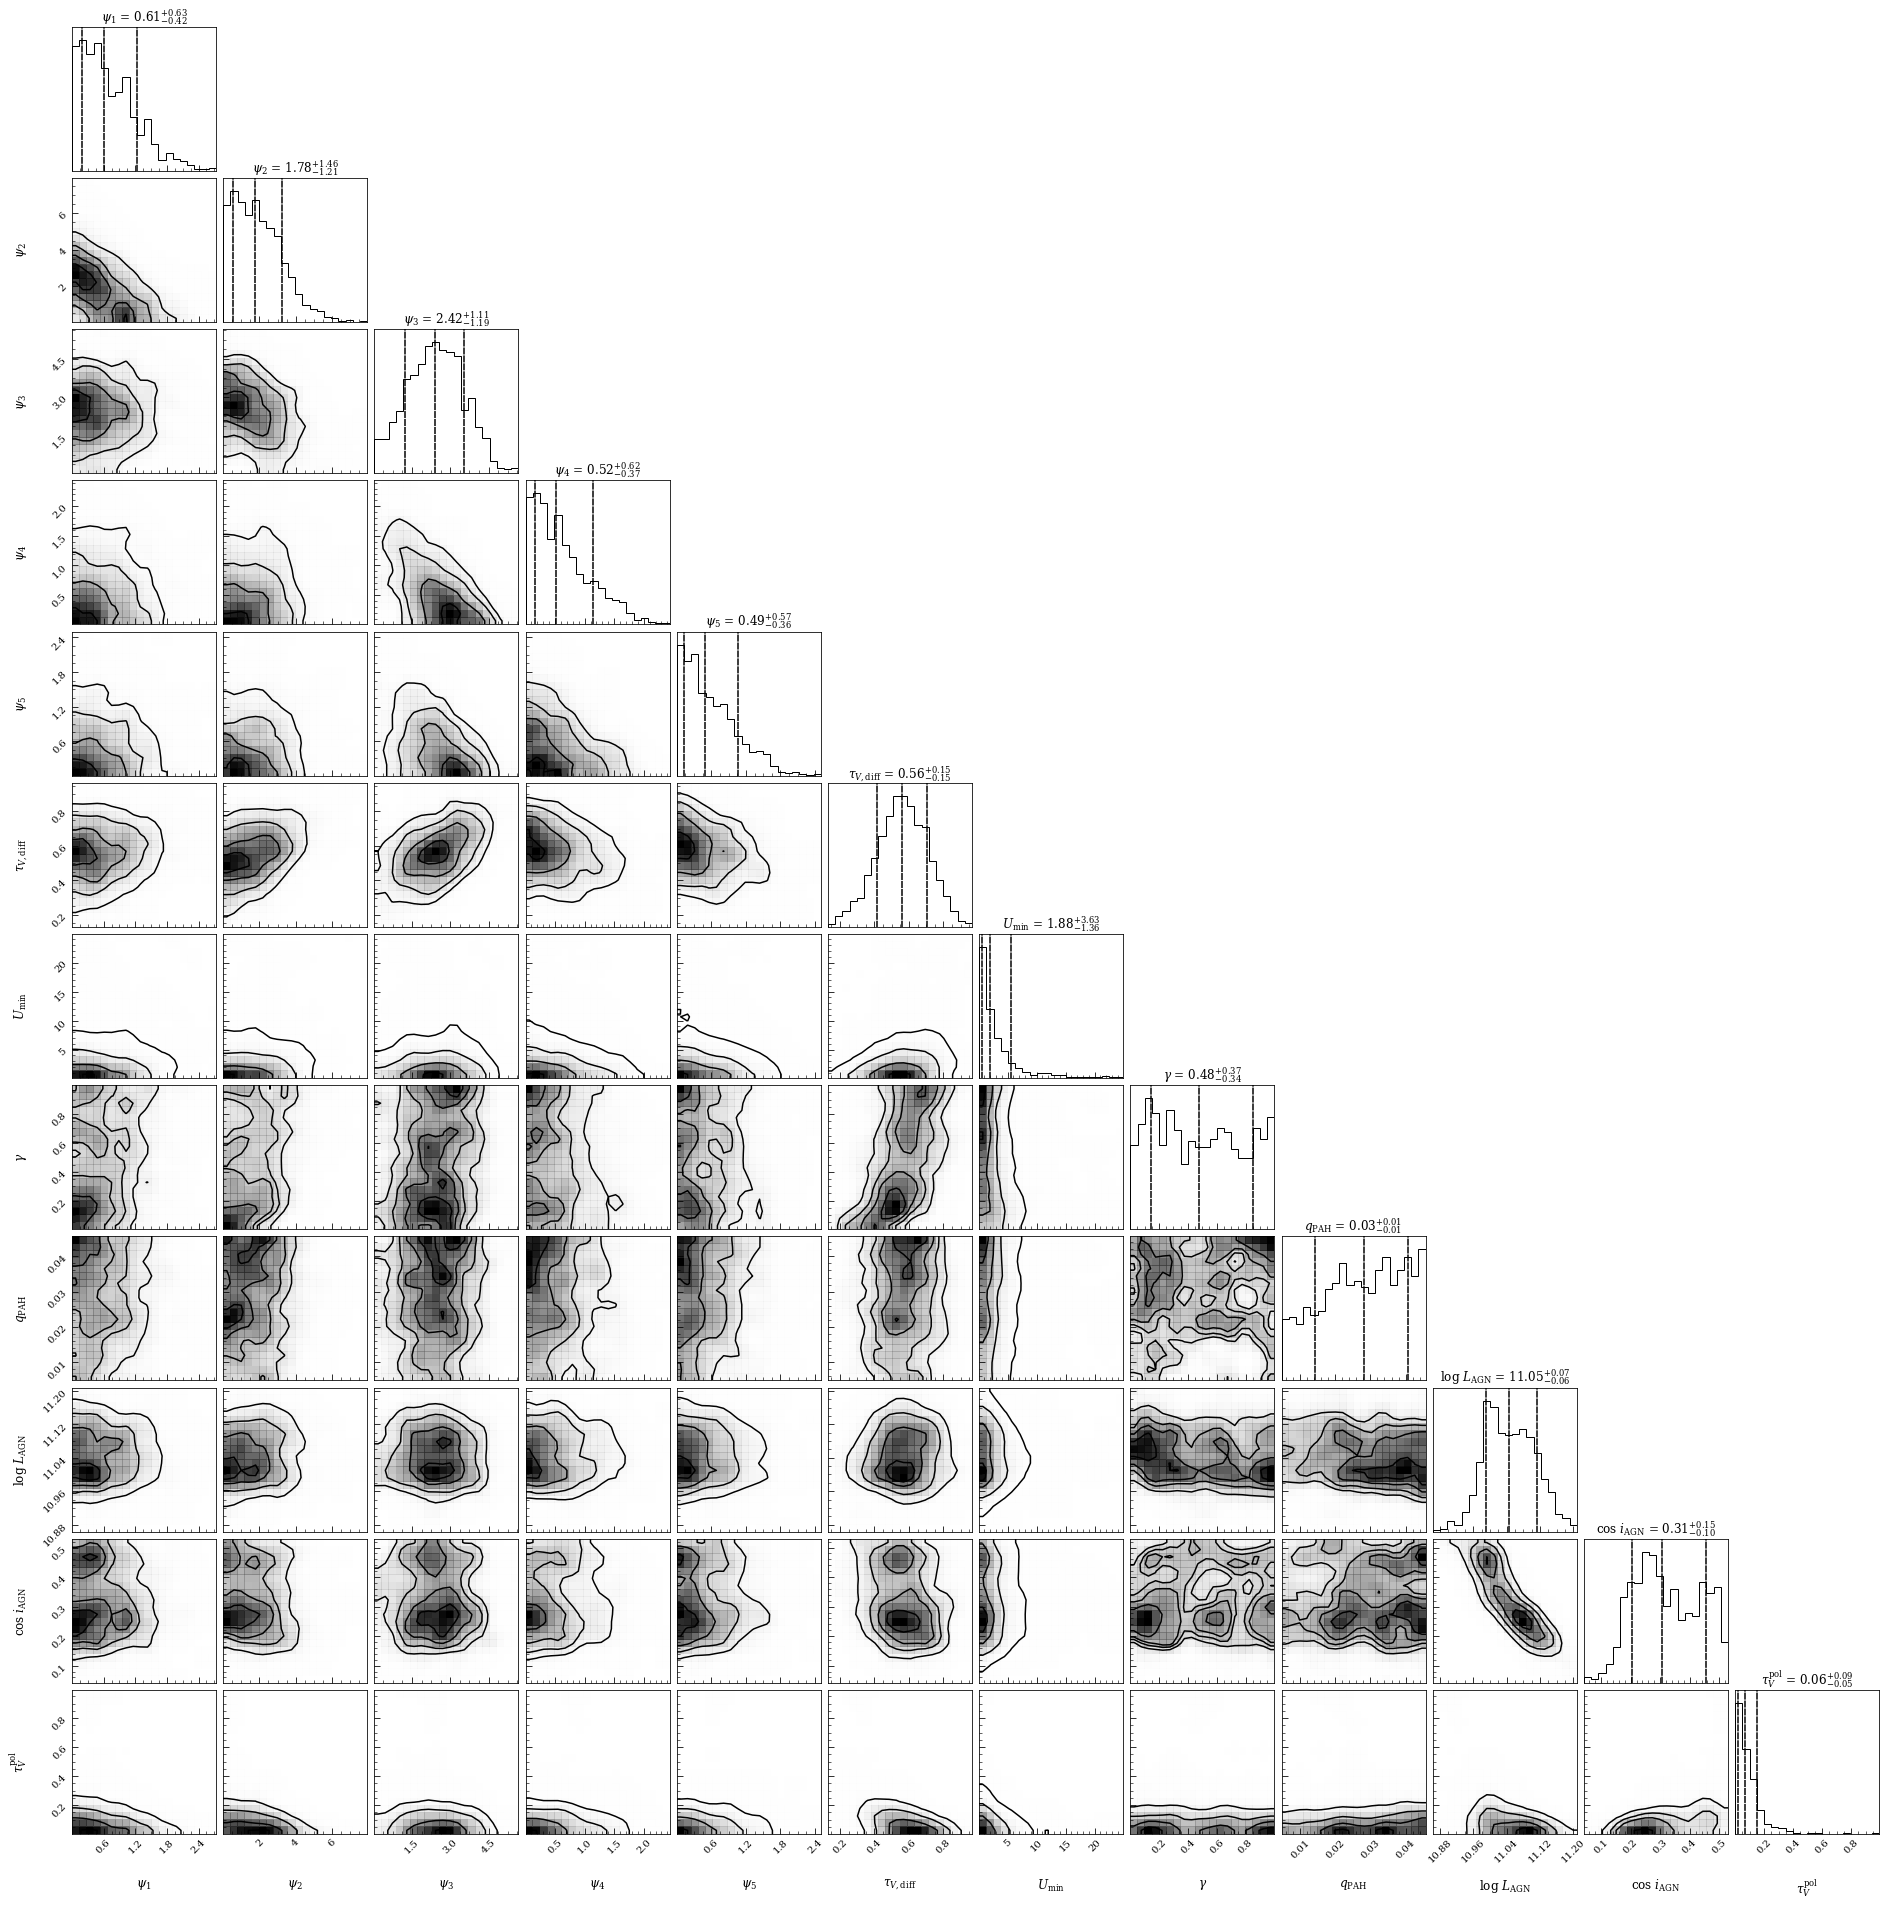

In [14]:
from lightning.plots import corner_plot

fig = corner_plot(l, param_arr, 
                  quantiles=(0.16, 0.50, 0.84),
                  smooth=1,
                  levels=None,
                  show_titles=True)

Sick.

### Best fit SED/Sampled SFH plot
This'll be our typical plot, with the best-fit SED and the 16th-84th percentile of the SFH. In the future this first block would be handled by a helper method of the `Lightning` class that ingests the fitting
result (MCMC sampler from `emcee`, optimization result from `scipy.optimize`, maybe `MultiNest`, who knows).

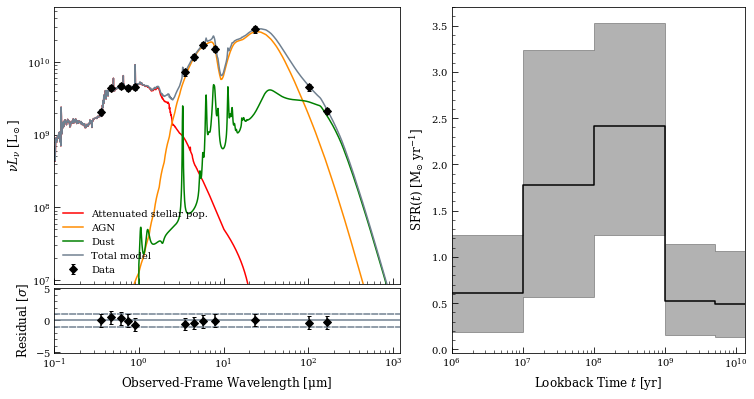

In [16]:
from lightning.plots import sed_plot_bestfit, sed_plot_delchi, sfh_plot

# # We can use the builtin plotting functions to make individual figures...
# fig1, ax1 = sed_plot_bestfit(l, param_arr, logprob_chain, plot_components=True)
# fig2, ax2 = sed_plot_delchi(l, param_arr, logprob_chain)
# fig3, ax3 = sfh_plot(l, param_arr)

# Or we can use them to make a complex (hopefully) publication quality 
# figure by laying out our axes and then using the `ax` keyword in each function:
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_axes([0.1, 0.26, 0.4, 0.64])
ax2 = fig.add_axes([0.1, 0.1, 0.4, 0.15])
ax3 = fig.add_axes([0.56, 0.1, 0.34, 0.8])

fig, ax1 = sed_plot_bestfit(l, param_arr, logprob_chain,
                            plot_components=True,
                            ax=ax1,
                            legend_kwargs={'loc': 'lower left', 'frameon': False})
ax1.set_xticklabels([])
fig, ax2 = sed_plot_delchi(l, param_arr, logprob_chain, ax=ax2)
fig, ax3 = sfh_plot(l, param_arr, ax=ax3)

Radical.

### Goodness of Fit
This is sort of pointless given that we simulated the data from the model, which is the thing the PPC tests.

p = 0.152


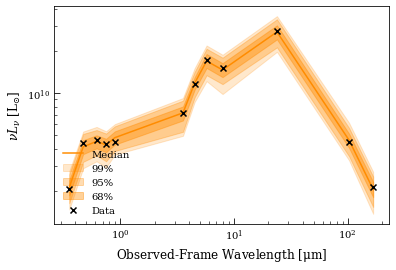

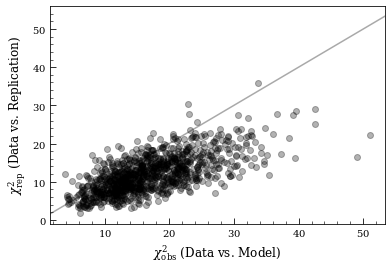

In [19]:
from lightning.ppc import ppc, ppc_sed

# I'm not thrilled about the way this works;
# the PPC needs all the parameters, even the constant
# ones. It's probably past time to make the MCMC fit function
# return a more user-friendly data structure that includes the
# constant values.
param_arr = np.zeros((chain.shape[0], l.Nparams))
param_arr[:, const_dim] = p[None, const_dim]
param_arr[:, var_dim] = chain
 
pvalue, chi2_rep, chi2_obs = ppc(l, param_arr,
                                 logprob_chain,
                                 Nrep=1000,
                                 seed=12345)
fig, ax = ppc_sed(l, param_arr,
                  logprob_chain,
                  Nrep=1000,
                  seed=12345,
                  normalize=False)

fig2, ax2 = plt.subplots()

ax2.scatter(chi2_obs,
            chi2_rep,
            marker='o',
            alpha=0.3)

xlim = ax2.get_xlim()
ax2.plot(xlim, xlim, linestyle='-', color='darkgray', zorder=-1)
ax2.set_xlim(xlim)

ax2.set_xlabel(r'$\chi_{\rm obs}^2$ (Data vs. Model)')
ax2.set_ylabel(r'$\chi_{\rm rep}^2$ (Data vs. Replication)')


print('p = %.3f' % (pvalue))